# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке. 

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)	
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту	
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета	
- **Fare**: стоимость проезда пассажира	
- **Cabin**: номер каюты	
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [172]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

Установите количество пропущенных значений поля <code>age</code>:

In [173]:
df_train = pd.read_csv('titanic_train.csv')
df_train

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,A. 2. 39186,8.0500,NaN,S,NaN
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,"England Oglesby, IL"
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,12233,13.0000,NaN,S,"Vancouver, BC"
979,3,0,"Barton, Mr. David John",male,22.0,0,0,324669,8.0500,NaN,S,"England New York, NY"


In [174]:
print(sum(df_train['age'].isna()))

199


Определите долю выживших

<Axes: xlabel='survived', ylabel='Count'>

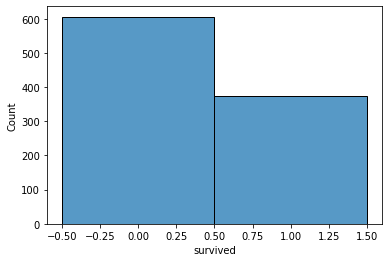

In [175]:
sns.histplot(df_train['survived'], discrete=True)

In [176]:
counts = df_train['survived'].value_counts()
print(counts[1]/sum(counts))

0.382262996941896


Определите долю пропущенных значений в рамках каждого признака и избавьтесь от тех признаков, где доля пропусков больше трети. Также удалите колонку <code>ticket</code>, вряд ли эта информация будет полезной.

In [177]:
missing_values = df_train.isnull().mean()
display(missing_values)

threshold = 1/3
columns_to_drop = missing_values[missing_values > threshold].index
df_train.drop(columns_to_drop, axis=1, inplace=True)
df_train.drop(['ticket'], axis=1, inplace=True)

pclass       0.000000
survived     0.000000
name         0.000000
sex          0.000000
age          0.202854
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.000000
cabin        0.783894
embarked     0.000000
home.dest    0.422018
dtype: float64

Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>. 

In [178]:
df_train['fam_size'] = df_train['sibsp'] + df_train['parch']
df_train.drop(columns=['sibsp', 'parch'], inplace=True)
df_train

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


In [179]:
# выборочное среднее fam_size
print(np.mean(df_train['fam_size']))

0.8664627930682977


Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [180]:
print(len(df_train.columns)-1)

7


На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [184]:
len(df_train.query('sex == "female" & pclass == 1 & survived ==1'))/len(df_train.query('sex == "female" & pclass == 1'))

0.9711538461538461

Постройте гистограммы выжиших и невыживших по возрастам.

<Axes: xlabel='age', ylabel='Count'>

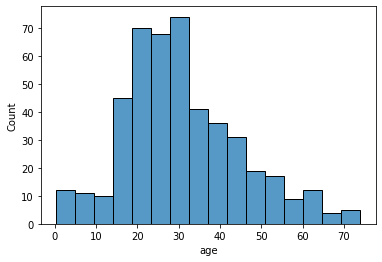

In [147]:
sns.histplot(data=df_train.query('survived == 0'), x='age')

<Axes: xlabel='age', ylabel='Count'>

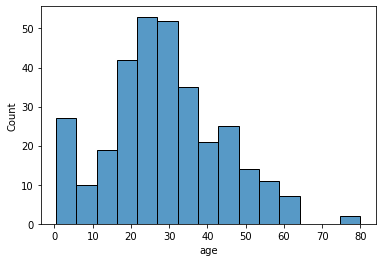

In [148]:
sns.histplot(data=df_train.query('survived == 1'), x='age')

# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [149]:
numeric_cols = df_train.select_dtypes(include='number').columns
df1 = df_train[numeric_cols]
df1 = df1.dropna()

In [150]:
X_train, X_test, y_train, y_test = train_test_split(df1.drop(columns=['survived']), df1['survived'], test_size=0.2, random_state=11, stratify=df1['survived'])

In [151]:
model = LogisticRegression(random_state=11, max_iter=1000)
model.fit(X_train, y_train)
f1_score(y_test, model.predict(X_test))

0.5471698113207547

## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [152]:
numeric_cols = df_train.select_dtypes(include='number').columns
df2 = df_train[numeric_cols]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    981 non-null    int64  
 1   survived  981 non-null    int64  
 2   age       782 non-null    float64
 3   fare      981 non-null    float64
 4   fam_size  981 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 38.4 KB


In [153]:
df2 = df2.fillna(np.mean(df2['age']))
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    981 non-null    int64  
 1   survived  981 non-null    int64  
 2   age       981 non-null    float64
 3   fare      981 non-null    float64
 4   fam_size  981 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 38.4 KB


In [154]:
X_train, X_test, y_train, y_test = train_test_split(df2.drop(columns=['survived']), df2['survived'], test_size=0.2, random_state=11, stratify=df2['survived'])
model = LogisticRegression(random_state=11, max_iter=1000)
model.fit(X_train, y_train)
f1_score(y_test, model.predict(X_test))

0.4297520661157025

## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку. 

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Вычислите число уникальных обращений.

In [155]:
import re
# Определяем функцию для поиска обращений в имени
def extract_title(name):
    title_search = re.search(r'([A-Z][a-z]+\.)', name)
    if title_search:
        return title_search.group()[:-1]  # Исключаем последнюю точку
    else:
        return None

# Создаем новый столбец 'title' и применяем функцию extract_title к столбцу 'name'
df_train['honorific'] = df_train['name'].apply(extract_title)

In [156]:
print(df_train['honorific'].unique())
print(df_train['honorific'].nunique())

['Miss' 'Mrs' 'Mr' 'Master' 'Mlle' 'Rev' 'Ms' 'Col' 'Dona' 'Dr' 'Countess'
 'Major' 'Don' 'Capt']
14


Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [157]:
Mr, Mrs, Miss = ['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'], ['Dona', 'Countess'], ['Mlle', 'Ms']

def change_name(name):
    if name in Mr:
        return 'Mr'
    elif name in Mrs:
        return 'Mrs'
    elif name in Miss:
        return 'Miss'
    else:
        return name
    
    
df_train['honorific'] = df_train['honorific'].apply(change_name)    

Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [158]:
len(df_train[df_train['honorific']=='Master'])/len(df_train[df_train['sex']=='male'])

0.07232704402515723

Вычислите средний возраст категории, указанной в вашем индивидуальном задании

In [159]:
np.mean(df_train[df_train['honorific']=='Miss']['age'])

22.00576540880503

Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [161]:
mean_miss = np.mean(df_train[df_train['honorific']=='Miss']['age'])
mean_master = np.mean(df_train[df_train['honorific']=='Master']['age'])
mean_mr = np.mean(df_train[df_train['honorific']=='Mr']['age'])
mean_mrs = np.mean(df_train[df_train['honorific']=='Mrs']['age'])

In [162]:
df_train['age'] = df_train.apply(lambda row: mean_miss if row['honorific'] == 'Miss' and pd.isnull(row['age']) else
                                  mean_master if row['honorific'] == 'Master' and pd.isnull(row['age']) else
                                  mean_mr if row['honorific'] == 'Mr' and pd.isnull(row['age']) else
                                  mean_mrs if row['honorific'] == 'Mrs' and pd.isnull(row['age']) else
                                  row['age'], axis=1)

df_train

In [164]:
numeric_cols = df_train.select_dtypes(include='number').columns
df3 = df_train[numeric_cols]
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    981 non-null    int64  
 1   survived  981 non-null    int64  
 2   age       981 non-null    float64
 3   fare      981 non-null    float64
 4   fam_size  981 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 38.4 KB


In [165]:
X_train, X_test, y_train, y_test = train_test_split(df3.drop(columns=['survived']), df3['survived'], test_size=0.2, random_state=11, stratify=df3['survived'])
model = LogisticRegression(random_state=11, max_iter=1000)
model.fit(X_train, y_train)
f1_score(y_test, model.predict(X_test))

0.43902439024390244

# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [169]:
df_train = pd.get_dummies(df_train.drop(columns=['name', 'honorific']), drop_first=True)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['survived']), df_train['survived'], test_size=0.2, random_state=11, stratify=df_train['survived'])
model = LogisticRegression(random_state=11, max_iter=1000)
model.fit(X_train, y_train)
f1_score(y_test, model.predict(X_test))

0.6575342465753424